### Plot Functions [1] 
```
Type: Maps
Projections: PlateCarree
Panels: One, multi(2)
```

*This notebook contains the functions to plot the maps using the data/variable provided.*

The different functions can be used to plot:
- *Contours*
- *Colored Pmesh*
- *Vectors*
- *Pmesh overlayed*

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import cartopy
import cartopy.crs as ccrs
from datetime import datetime
import numpy as np
import os
from cdo import Cdo
import tempfile
import inspect

***Plot and save the given magnitude as a mesh plot.***

In [2]:
def plot_and_save_pmesh(lns, lts, magnitude, output_filename=None, 
                        title=None, title_size=16,
                        vmin=None, vmax=None, clrmap=None, 
                        lbl=None, shrnk=None, lbl_size=12):
    """
    Plot and save the given variable's magnitude as a mesh plot.

    Parameters:
    - lns: 2D numpy array, longitudes.
    - lts: 2D numpy array, latitudes.
    - magnitude: 2D numpy array, wind speed magnitude.
    - output_filename: str, the name of the output image file (e.g., 'wind_vectors.png').
    - title: str, the title of the plot (default is None).
    - title_size: int, the font size of the figure title (default is 16).
    - vmin: float, minimum value for the color scale (default is None).
    - vmax: float, maximum value for the color scale (default is None).
    - clrmap: str, colormap name (default is None).
    - lbl: str, label for the colorbar (default is None).
    - lbl_size: int, the font size of the colorbar label (default is 12).
    - shrnk: float, fraction of the original colorbar size (default is 0.85).
    """

    # Create a figure and axis with a specified projection (PlateCarree)
    fig = plt.figure(figsize=(20, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Create a mesh plot of wind speed magnitude with specified vmin and vmax
    mesh = ax.pcolormesh(lns, lts, magnitude, transform=ccrs.PlateCarree(), 
                         cmap=clrmap, shading='auto',
                         vmin=vmin, vmax=vmax)

    # Add gridlines and coastlines
    ax.gridlines(draw_labels=False,linewidth=0.0)  # Turn off grid lines
    ax.coastlines()

    # Set plot title and labels
    if title:
        plt.title(title, fontsize=title_size)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add a colorbar
    if lbl:
        cbar = plt.colorbar(mesh, label=lbl, orientation='horizontal', 
                            pad=0.03, shrink=shrnk)
        cbar.ax.tick_params(labelsize=lbl_size-5)
        cbar.set_label(lbl, fontsize=lbl_size)

    # Save the plot as an image file (PDF format for high quality)
    plt.show()
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
        # plt.savefig(output_filename, format='pdf', bbox_inches='tight', dpi=300)

    # Close the current figure to release resources
    plt.close()

***Plot and save wind vectors as an image file.***

In [3]:
def plot_and_save_wind_vectors(lns, lts, uwind, vwind, magnitude, output_filename=None, 
                               title=None, title_size=16,
                               vmin=None, vmax=None, clrmap=None, 
                               lbl=None, shrnk=None, lbl_size=12):
    """
    Plot and save wind vectors as an image file.

    Parameters:
    - lns: 2D numpy array, longitudes.
    - lts: 2D numpy array, latitudes.
    - magnitude: 2D numpy array, wind speed magnitude.
    - output_filename: str, the name of the output image file (e.g., 'wind_vectors.png').
    - title: str, the title of the plot (default is None).
    - title_size: int, the font size of the figure title (default is 16).
    - vmin: float, minimum value for the color scale (default is None).
    - vmax: float, maximum value for the color scale (default is None).
    - clrmap: str, colormap name (default is None).
    - lbl: str, label for the colorbar (default is None).
    - shrnk: float, fraction of the original colorbar size (default is None).
    - lbl_size: int, the font size of the colorbar label (default is 12).
    """

    # Create a figure and axis with a specified projection
    fig = plt.figure(figsize=(20, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Predefined colormap dictionary
    colormap_dict = {
        'viridis': cm.viridis,
        'plasma': cm.plasma,
        'inferno': cm.inferno,
        'magma': cm.magma,
        'cividis': cm.cividis,
        'Blues': cm.Blues
        # Add more colormap names and their corresponding cmap values as needed
    }

    # Check if the provided colormap exists in the colormap dictionary
    if clrmap in colormap_dict:
        cmap = colormap_dict[clrmap]
    else:
        # Set a default colormap (e.g., viridis) if the provided colormap name is not found
        cmap = cm.viridis

    # Create a coloured quiver plot of wind speed magnitude with specified vmin and vmax
    quiver = ax.quiver(uwind.lon, uwind.lat, uwind, vwind, magnitude, transform=ccrs.PlateCarree(), cmap=cmap, scale=1000,
                       headaxislength=2, pivot='middle',  linewidth=0.000005, headlength=.25, headwidth=.5,)

    # Add gridlines and coastlines
    ax.gridlines(draw_labels=True)
    ax.coastlines()

    # Set plot title and labels
    if title:
        plt.title(title, fontsize=title_size)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add a colorbar
    if lbl:
        cbar = plt.colorbar(quiver, label=lbl, orientation='horizontal', pad=0.03, shrink=shrnk)
        cbar.ax.tick_params(labelsize=lbl_size-5)
        cbar.set_label(lbl, fontsize=lbl_size)

    # Save the plot as an image file
    plt.show()
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')

    # Close the current figure to release resources
    plt.close()


***Plot and save a given variable magnitude as a contour plot.***

In [4]:
def plot_and_save_contour(lns, lts, magnitude, output_filename=None,
                          title=None, title_size=16,
                          vmin=None, vmax=None, clrmap=None,
                          lbl=None, shrnk=None, lbl_size=12):
    """
    Plot and save a given variable's magnitude as a contour plot.

    Parameters:
    - lns: 2D numpy array, longitudes.
    - lts: 2D numpy array, latitudes.
    - magnitude: 2D numpy array, wind speed magnitude.
    - output_filename: str, the name of the output image file (e.g., 'wind_vectors.png').
    - title: str, the title of the plot (default is None).
    - title_size: int, the font size of the figure title (default is 16).
    - vmin: float, minimum value for the color scale (default is None).
    - vmax: float, maximum value for the color scale (default is None).
    - clrmap: str, colormap name (default is None).
    - lbl: str, label for the colorbar (default is None).
    - lbl_size: int, the font size of the colorbar label (default is 12).
    - shrnk: float, fraction of the original colorbar size (default is 0.85).
    """

    # Create a figure and axis with a specified projection (PlateCarree)
    fig = plt.figure(figsize=(20, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Create a contour plot of wind speed magnitude with specified vmin and vmax
    contour = ax.contourf(lns, lts, magnitude, cmap=clrmap, levels=20,
                          vmin=vmin, vmax=vmax, extend='both')

    # Add gridlines and coastlines
    ax.gridlines(draw_labels=False, linewidth=0.0)  # Turn off grid lines
    ax.coastlines()

    # Set plot title and labels
    if title:
        plt.title(title, fontsize=title_size)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add a colorbar
    if lbl:
        cbar = plt.colorbar(contour, label=lbl, orientation='horizontal',
                            pad=0.03, shrink=shrnk)
        cbar.ax.tick_params(labelsize=lbl_size - 5)
        cbar.set_label(lbl, fontsize=lbl_size)

    # Save the plot as an image file (PDF format for high quality)
    plt.show()
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')

    # Close the current figure to release resources
    plt.close()

***Overlays pressure level contour lines***

In [5]:
def plot_and_save_pmesh_overlay(lns, lts, mag1, mag2, contour1, contour2, output_filename=None, 
                            title1=None, title2=None, mntitle=None, mntpos=None, title_size=16, mntitle_size=20,
                            vmin=None, vmax=None, clrmap=None, lbl=None, lbl_size=12, cbht=75, triends=None, rsltn=None):
    """
    Plot and save a given two magnitudes as two side-by-side subplots with a common colorbar at the bottom
    and overlay contour lines on the plots with contour values.

    Parameters:
    - lns: 2D numpy array, longitudes.
    - lts: 2D numpy array, latitudes.
    - mag1: 2D numpy array, wind speed magnitude for the first subplot.
    - mag2: 2D numpy array, wind speed magnitude for the second subplot.
    - contour1: 2D numpy array, contour data for the first subplot.
    - contour2: 2D numpy array, contour data for the second subplot.
    - output_filename: str, the name of the output image file (e.g., 'wind_vectors.png').
    - title1: str, title for the first subplot (default is None).
    - title2: str, title for the second subplot (default is None).
    - title_size: int, the font size of the figure title (default is 16).
    - mntitle: str, maintitle for the figure (default is None).
    - mntpos: float, vertical (y) position of the maintitle (default in None).
    - mntitle_size: int, the font size of the figure title (default is 20).
    - vmin: float, minimum value for the color scale (default is None).
    - vmax: float, maximum value for the color scale (default is None).
    - clrmap: str, colormap name (default is None).
    - lbl: str, label for the colorbar (default is None).
    - lbl_size: int, the font size of the colorbar label (default is 12).
    - cbht: float, aspect of the colorbar (default in 75).
    - triends: str, triangular end options (default is None; replace by 'min', 'max' or 'both').
    - rsltn: int, resolution of the plot in dpi (default is None).
    """

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot wind speed magnitude in the first subplot
    mesh1 = axes[0].pcolormesh(lns, lts, mag1, transform=ccrs.PlateCarree(), cmap=clrmap, shading='auto',
                               vmin=vmin, vmax=vmax)

    # Overlay contour lines on the first subplot with contour values
    contour1_plot = axes[0].contour(lns, lts, contour1, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.clabel(contour1_plot, inline=True, fontsize=10, fmt='%1.1f')

    # Add gridlines and coastlines to the first subplot
    axes[0].gridlines(draw_labels=True, linewidth=0.0)
    axes[0].coastlines(linewidth=0.05)

    # Set title and labels for the first subplot
    if title1:
        axes[0].set_title(title1, fontsize=title_size)
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')

    # Plot wind speed magnitude in the second subplot
    mesh2 = axes[1].pcolormesh(lns, lts, mag2, transform=ccrs.PlateCarree(), cmap=clrmap, shading='auto',
                               vmin=vmin, vmax=vmax)

    # Overlay contour lines on the second subplot with contour values
    contour2_plot = axes[1].contour(lns, lts, contour2, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.clabel(contour2_plot, inline=True, fontsize=10, fmt='%1.1f')

    # Add gridlines and coastlines to the second subplot
    axes[1].gridlines(draw_labels=True, linewidth=0.0)
    axes[1].coastlines(linewidth=0.05)

    # Set title and labels for the second subplot
    if title2:
        axes[1].set_title(title2, fontsize=title_size)
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')

    # Create a single colorbar that spans both subplots at the bottom
    cbar = fig.colorbar(mesh2, ax=axes, orientation='horizontal', label=lbl ,pad=0.05, aspect=cbht, extend=triends)
    cbar.ax.tick_params(labelsize=lbl_size-2)
    cbar.set_label(lbl, fontsize=lbl_size)

    # main title
    if mntitle:
        plt.suptitle(mntitle, fontsize=mntitle_size, y=mntpos)  # Adjust the 'y' parameter to change the vertical position

    # Save the plot as an image file
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight', format='png', dpi=rsltn)
    # Show and save the plot    
    plt.show()
    # Close the current figure to release resources
    plt.close()


***Plot and save wind vectors overlayed with wind speed contours.***

In [6]:
def plot_and_save_wind_ConVec(lns, lts, magnitude, output_filename=None, title=None, title_size=16,
                               vmin=None, vmax=None, clrmap=None, lbl=None, shrnk=None, lbl_size=12,
                               uwind=None, vwind=None):
    """
    Plot and save wind vectors as an image file with contour and quiver plots.

    Parameters:
    - lns: 2D numpy array, longitudes.
    - lts: 2D numpy array, latitudes.
    - magnitude: 2D numpy array, wind speed magnitude.
    - output_filename: str, the name of the output image file (e.g., 'wind_vectors.png').
    - title: str, the title of the plot (default is None).
    - title_size: int, the font size of the figure title (default is 16).
    - vmin: float, minimum value for the color scale (default is None).
    - vmax: float, maximum value for the color scale (default is None).
    - clrmap: str, colormap name (default is None).
    - lbl: str, label for the colorbar (default is None).
    - shrnk: float, fraction of the original colorbar size (default is None).
    - lbl_size: int, the font size of the colorbar label (default is 12).
    - uwind: 2D numpy array, horizontal wind component (default is None).
    - vwind: 2D numpy array, vertical wind component (default is None).
    """

    # Create a figure and axis with a specified projection
    fig = plt.figure(figsize=(20, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Predefined colormap dictionary
    colormap_dict = {
        'viridis': cm.viridis,
        'plasma': cm.plasma,
        'inferno': cm.inferno,
        'magma': cm.magma,
        'cividis': cm.cividis,
        'Blues': cm.Blues
        # Add more colormap names and their corresponding cmap values as needed
    }

    # Check if the provided colormap exists in the colormap dictionary
    if clrmap in colormap_dict:
        cmap = colormap_dict[clrmap]
    else:
        # Set a default colormap (e.g., viridis) if the provided colormap name is not found
        cmap = cm.viridis

    # Create a mesh plot of wind speed magnitude with specified vmin and vmax
    mesh = ax.pcolormesh(lns, lts, magnitude, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto',
                         vmin=vmin, vmax=vmax)

    # Add gridlines and coastlines
    ax.gridlines(draw_labels=True)
    ax.coastlines()

    # Set plot title and labels
    if title:
        plt.title(title, fontsize=title_size)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add quiver plots if uwind and vwind are provided
    if uwind is not None and vwind is not None:
        # quiver = ax.quiver(lns, lts, uwind, vwind, transform=ccrs.PlateCarree(),
        #                    scale=1000, headaxislength=5, pivot='middle', color='white',
        #                    linewidth=0.1)
        
        quiver = ax.quiver(lns, lts, uwind, vwind, transform=ccrs.PlateCarree(),
                   scale=1000, headlength=.25, headwidth=.5, pivot='middle', color='white',
                   linewidth=0.000005, alpha=0.5, headaxislength=2)


    # Add a colorbar
    if lbl:
        cbar = plt.colorbar(mesh, label=lbl, orientation='horizontal', pad=0.03, shrink=shrnk)
        cbar.ax.tick_params(labelsize=lbl_size-5)
        cbar.set_label(lbl, fontsize=lbl_size)

    # Save the plot as an image file
    plt.show()
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight', dpi=300)

    # Close the current figure to release resources
    plt.close()

***Plots two magnitudes and difference***

In [7]:
def plot_and_save_pmesh_diff(lns, lts, mag1, mag2, 
                                 output_filename=None, mntitle=None, mntitle_size=20, mntpos=None,  
                                 title1=None, title2=None,  title_diff=None, title_size=16, 
                                 clrmap=None,  diff_clrmap=None, vmin=None, vmax=None, vmin_diff=None, vmax_diff=None,
                                 lbl=None, lbl_diff=None,  lbl_size=12, lbl_size_diff=12, cbht=75, cbht_diff=75, 
                                 triends=None, triends_diff=None, rsltn=None,):
                             
    
    """
    Plot and save wind speed magnitude as two rows of subplots, with the first row containing
    plots with similar colormaps and a shared colorbar, and the second row containing only the difference maps
    with a separate colorbar.

    Parameters:
    - lns: 2D numpy array, longitudes.
    - lts: 2D numpy array, latitudes.
    - mag1: 2D numpy array, wind speed magnitude for the first subplot.
    - mag2: 2D numpy array, wind speed magnitude for the second subplot.
    - output_filename: str, the name of the output image file (e.g., 'wind_vectors.png').
    - title1: str, title for the first subplot (default is None).
    - title2: str, title for the second subplot (default is None).
    - title_diff: str, title for the difference subplot (default is None).
    - title_size: int, the font size of the figure title (default is 16).
    - mntitle: str, maintitle for the figure (default is None).
    - mntpos: float, vertical (y) position of the maintitle (default in None).
    - mntitle_size: int, the font size of the figure title (default is 20).
    - vmin: float, minimum value for the color scale (default is None).
    - vmax: float, maximum value for the color scale (default is None).
    - clrmap: str, colormap name for mag1 and mag2 (default is None).
    - lbl: str, label for the colorbar of mag1 and mag2 (default is None).
    - lbl_size: int, the font size of the colorbar labels (default is 12).
    - cbht: float, aspect of the colorbar for mag1 and mag2 (default in 75).
    - triends: str, triangular end options (default is None; replace by 'min', 'max' or 'both').
    - rsltn: int, resolution of the plot in dpi (default is None).
    - vmin_diff: float, minimum value for the color scale of the difference plot (default is None).
    - vmax_diff: float, maximum value for the color scale of the difference plot (default is None).
    - diff_clrmap: str, colormap name for the difference plot (default is None).
    - lbl_diff: str, label for the colorbar of the difference plot (default is None).
    - lbl_size_diff: int, the font size of the colorbar label for the difference plot (default is 12).
    - cbht_diff: float, aspect of the colorbar for the difference plot (default in 75).
    """

    # Create a figure with two rows and two columns
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot wind speed magnitude in the first subplot (top left)
    mesh1 = axes[0, 0].pcolormesh(lns, lts, mag1, transform=ccrs.PlateCarree(), cmap=clrmap, shading='auto',
                                  vmin=vmin, vmax=vmax)
    # Add gridlines and coastlines to the first subplot
    axes[0, 0].gridlines(draw_labels=True, linewidth=0.0)
    axes[0, 0].coastlines(linewidth=0.05)
    # Set title and labels for the first subplot
    if title1:
        axes[0, 0].set_title(title1, fontsize=title_size)
    axes[0, 0].set_xlabel('Longitude')
    axes[0, 0].set_ylabel('Latitude')

    # Plot wind speed magnitude in the second subplot (top right)
    mesh2 = axes[0, 1].pcolormesh(lns, lts, mag2, transform=ccrs.PlateCarree(), cmap=clrmap, shading='auto',
                                  vmin=vmin, vmax=vmax)
    # Add gridlines and coastlines to the second subplot
    axes[0, 1].gridlines(draw_labels=True, linewidth=0.0)
    axes[0, 1].coastlines(linewidth=0.05)
    # Set title and labels for the second subplot
    if title2:
        axes[0, 1].set_title(title2, fontsize=title_size)
    axes[0, 1].set_xlabel('Longitude')
    axes[0, 1].set_ylabel('Latitude')

    # Calculate the difference between mag1 and mag2
    diff = mag1 - mag2

    # Plot the difference between the two magnitude fields in the third subplot (bottom left)
    diff_cbar = ScalarMappable(norm=Normalize(vmin=vmin_diff, vmax=vmax_diff), cmap=diff_clrmap)
    mesh_diff = axes[1, 0].pcolormesh(lns, lts, diff, transform=ccrs.PlateCarree(), cmap=diff_cbar.cmap,
                                     shading='auto', vmin=vmin_diff, vmax=vmax_diff)
    # Add gridlines and coastlines to the third subplot
    axes[1, 0].gridlines(draw_labels=True, linewidth=0.0)
    axes[1, 0].coastlines(linewidth=0.05)
    # Set title and labels for the third subplot
    axes[1, 0].set_title(title_diff, fontsize=title_size)
    axes[1, 0].set_xlabel('Longitude')
    axes[1, 0].set_ylabel('Latitude')

    # Create a colorbar for the difference plot (bottom left)
    cbar_diff = fig.colorbar(mesh_diff, ax=axes[1, 0], orientation='horizontal', label=lbl_diff, pad=0.075, aspect=cbht_diff, extend=triends_diff)
    cbar_diff.ax.tick_params(labelsize=lbl_size_diff-2)
    cbar_diff.set_label(lbl, fontsize=lbl_size_diff)

    
    # Remove the empty subplot in the bottom right
    fig.delaxes(axes[1, 1])

    # Create a single colorbar for the first row (top row)
    cbar = fig.colorbar(mesh2, ax=axes[0, :], orientation='horizontal', label=lbl, pad=0.075, aspect=cbht, extend=triends)
    cbar.ax.tick_params(labelsize=lbl_size-2)
    cbar.set_label(lbl, fontsize=lbl_size)
    
    # main title
    if mntitle:
        plt.suptitle(mntitle, fontsize=mntitle_size, y=mntpos)  # Adjust the 'y' parameter to change the vertical position

    # Save the plot as an image file
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight', format='png', dpi=rsltn)
    # Show and save the plot    
    plt.show()
    # Close the current figure to release resources
    plt.close()

***Subset a NetCDF file using CDO's sellonlatbox operation and return the result as an xarray Dataset.***

***If latlon values are None, the function will open the file without subsetting.***
```
<use>

%run "other_notebook.ipynb"
my_function()  # Assuming my_function is defined in other_notebook.ipynb

```

#### Testing fuctions

In [8]:
# run the crop notebook
%run "/work/ab0995/a270229/work/ntbks/py_lumi/crop_data.ipynb"

In [9]:
file_uin = '/work/ab0995/a270229/work/test/tco1279_runs/data/u10.nc'
file_vin = '/work/ab0995/a270229/work/test/tco1279_runs/data/v10.nc'

# lon1 = 270 #-180 #-10 # -180 Starting longitude :None 
# lon2 = 360 #180 #60  # 180  Ending longitude   :None
# lat1 = 10  # -90  Starting latitude  :None
# lat2 = 60  # 90   Ending latitude    :None

lon1 = None
lon2 = None
lat1 = None
lat2 = None

In [10]:
source_code = inspect.getsource(xr_subset_nc_file)
print(source_code)

def xr_subset_nc_file(file_path, lon1=None, lon2=None, lat1=None, lat2=None):
    """
    Subset a NetCDF file using xarray indexing and return the result as an xarray Dataset.
    If latlon values are None, the function will open the file without subsetting.

    Parameters:
    - file_path: str, path to the input NetCDF file.
    - lon1: float or None, starting longitude for subsetting.
    - lon2: float or None, ending longitude for subsetting.
    - lat1: float or None, starting latitude for subsetting.
    - lat2: float or None, ending latitude for subsetting.

    Returns:
    - result_ds: xarray.Dataset, the subsetted dataset or the original dataset if latlon values are None.
    
    Example usage:
    - subset_result = subset_nc_file('/work/ab0995/a270229/work/test/tco1279_runs/data/t2.nc', 4, 7, 50, 55)
    - or without subsetting:
    - original_ds = subset_nc_file('/work/ab0995/a270229/work/test/tco1279_runs/data/t2.nc', None, None, None, None)
    """

    # Open the NetCD

In [11]:
# Opens the ncfile by subsetting or not

# uf = cdo_subset_nc_file(file_uin, lon1, lon2, lat1, lat2)
# vf = cdo_subset_nc_file(file_vin, lon1, lon2, lat1, lat2)

uf = xr_subset_nc_file(file_uin, lon1, lon2, lat1, lat2)
vf = xr_subset_nc_file(file_vin, lon1, lon2, lat1, lat2)

In [12]:
# # Full resolution
# u = uf.isel(height=0)['10u']
# v = vf.isel(height=0)['10v']

# Don't want all the lat and lon values use this
u = uf.isel(lon=slice(0, -1, 20), lat=slice(1, -1, 20), height=0)['10u']
v = vf.isel(lon=slice(0, -1, 20), lat=slice(1, -1, 20), height=0)['10v']

- another fuction to select the latlon domain of interest 
```
use
xr_subset_xarray(ds , lon1, lon2, lat1, lat2)
```

### Sample Plots 

***Wind speed***

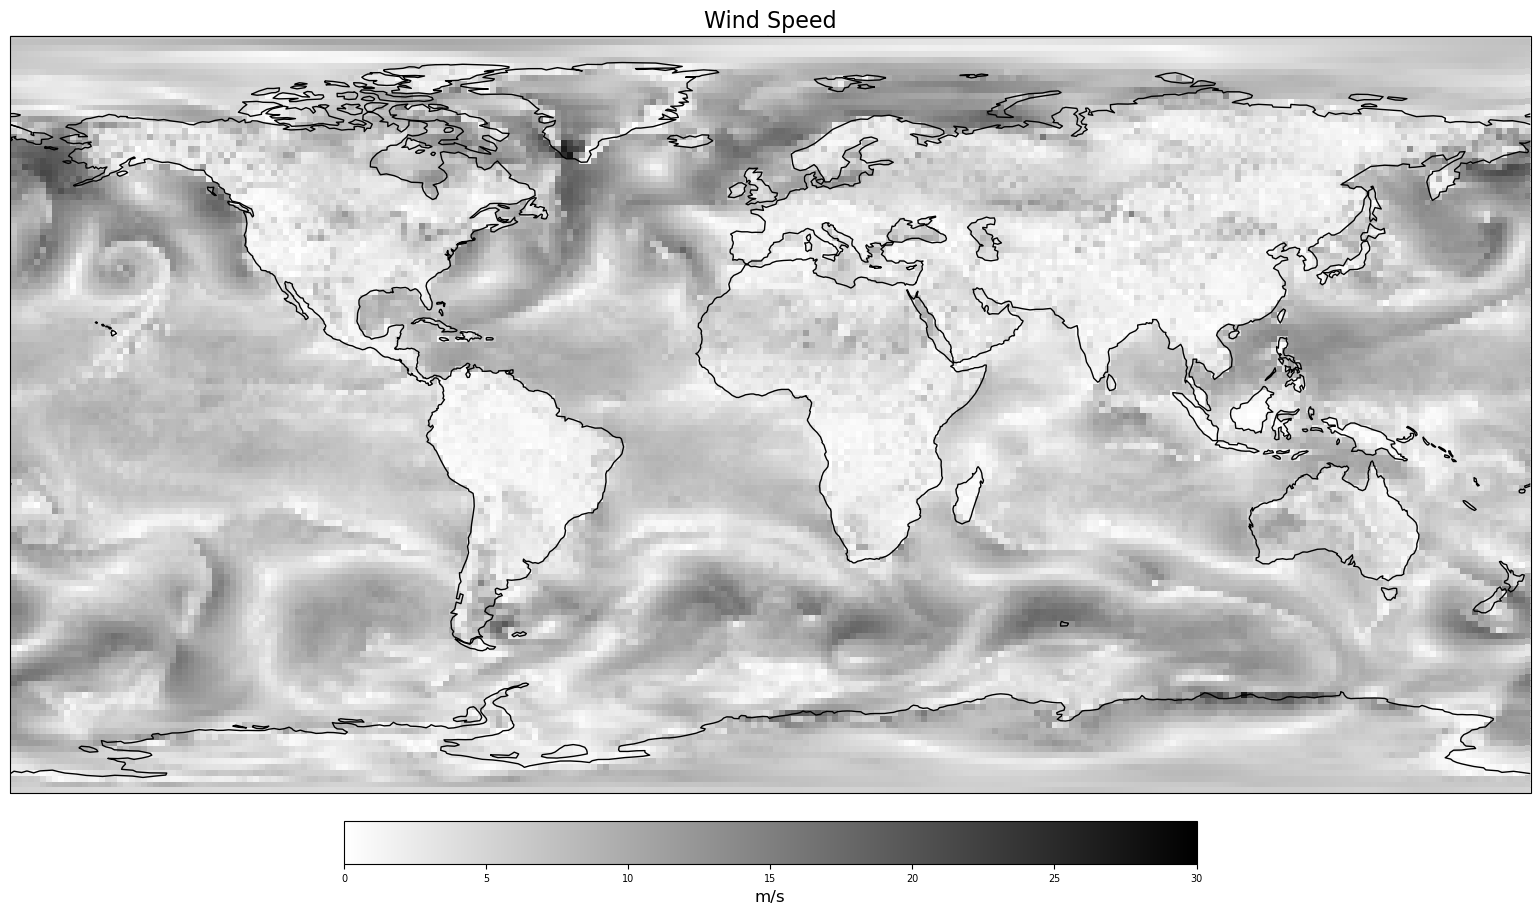

In [13]:
magnitude = np.sqrt(u[0]**2 + v[0]**2)
lns =u.lon
lts =u.lat
output_filename = None #'wind_speed.png'
title = 'Wind Speed'

plot_and_save_pmesh(lns, lts, magnitude, output_filename, title, 
                    vmin=0, vmax=30, clrmap='binary', lbl='m/s',
                    title_size=16,shrnk=0.55,lbl_size=12)

***Pmesh with overlay***

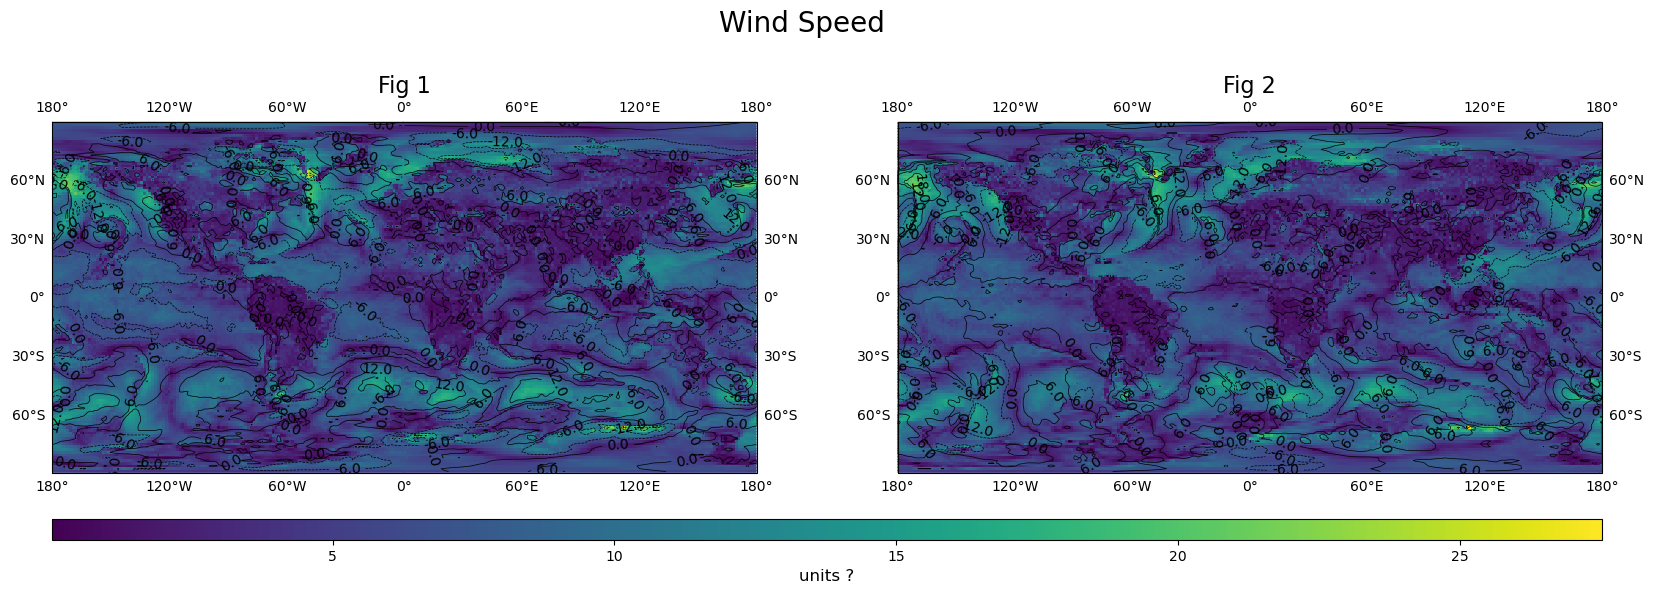

In [14]:
output_filename = None #'wind_speed.png'
title = 'Wind Speed'

plot_and_save_pmesh_overlay(lns, lts, magnitude, magnitude, u[0], v[0], output_filename, 
                            title1='Fig 1', title2='Fig 2', mntitle=title, mntpos=0.65, title_size=16, mntitle_size=20,
                            vmin=None, vmax=None, clrmap=None, lbl='units ?', lbl_size=12, cbht=75, triends=None, rsltn=None)

***Wind vectors***

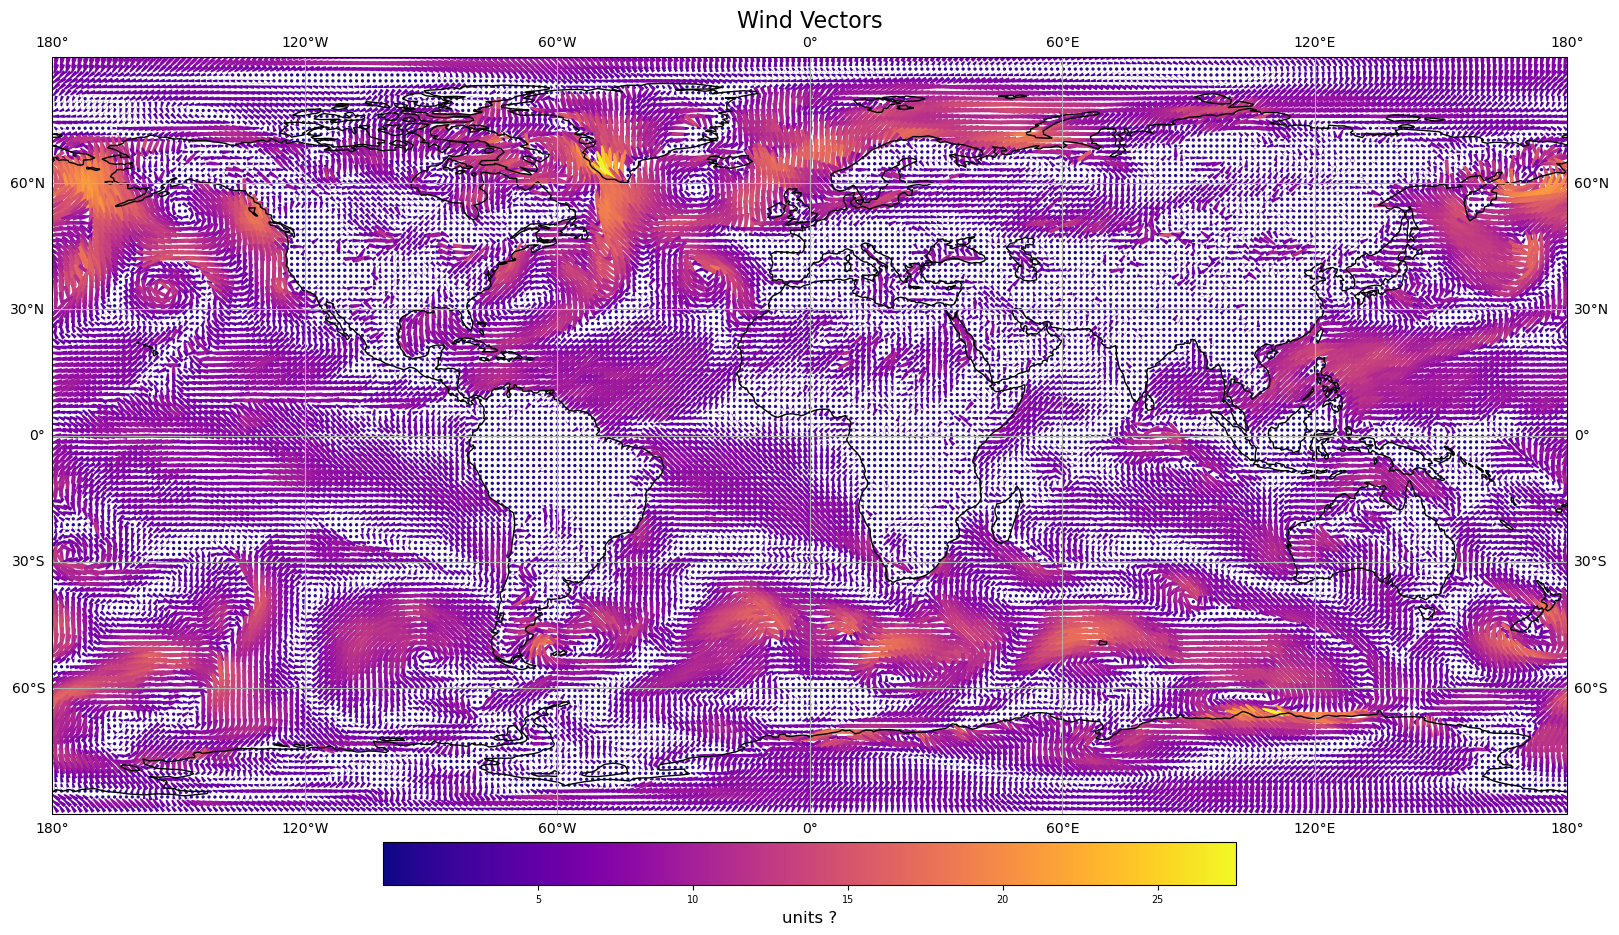

In [15]:
uu = u #.isel(lon=slice(0, -1, 20), lat=slice(1, -1, 20))
vv = v #.isel(lon=slice(0, -1, 20), lat=slice(1, -1, 20))

magnitude = np.sqrt(uu[0]**2 + vv[0]**2)
lns =uu.lon
lts =uu.lat

output_filename = None #'wind_vctrs.png'
title = 'Wind Vectors'

plot_and_save_wind_vectors(lns, lts, uu[0], vv[0], magnitude, output_filename, 
                               title, title_size=16,
                               vmin=None, vmax=None, clrmap='plasma', 
                               lbl='units ?', shrnk=0.55, lbl_size=12)

***Magnitude overlayed by wind vectors***

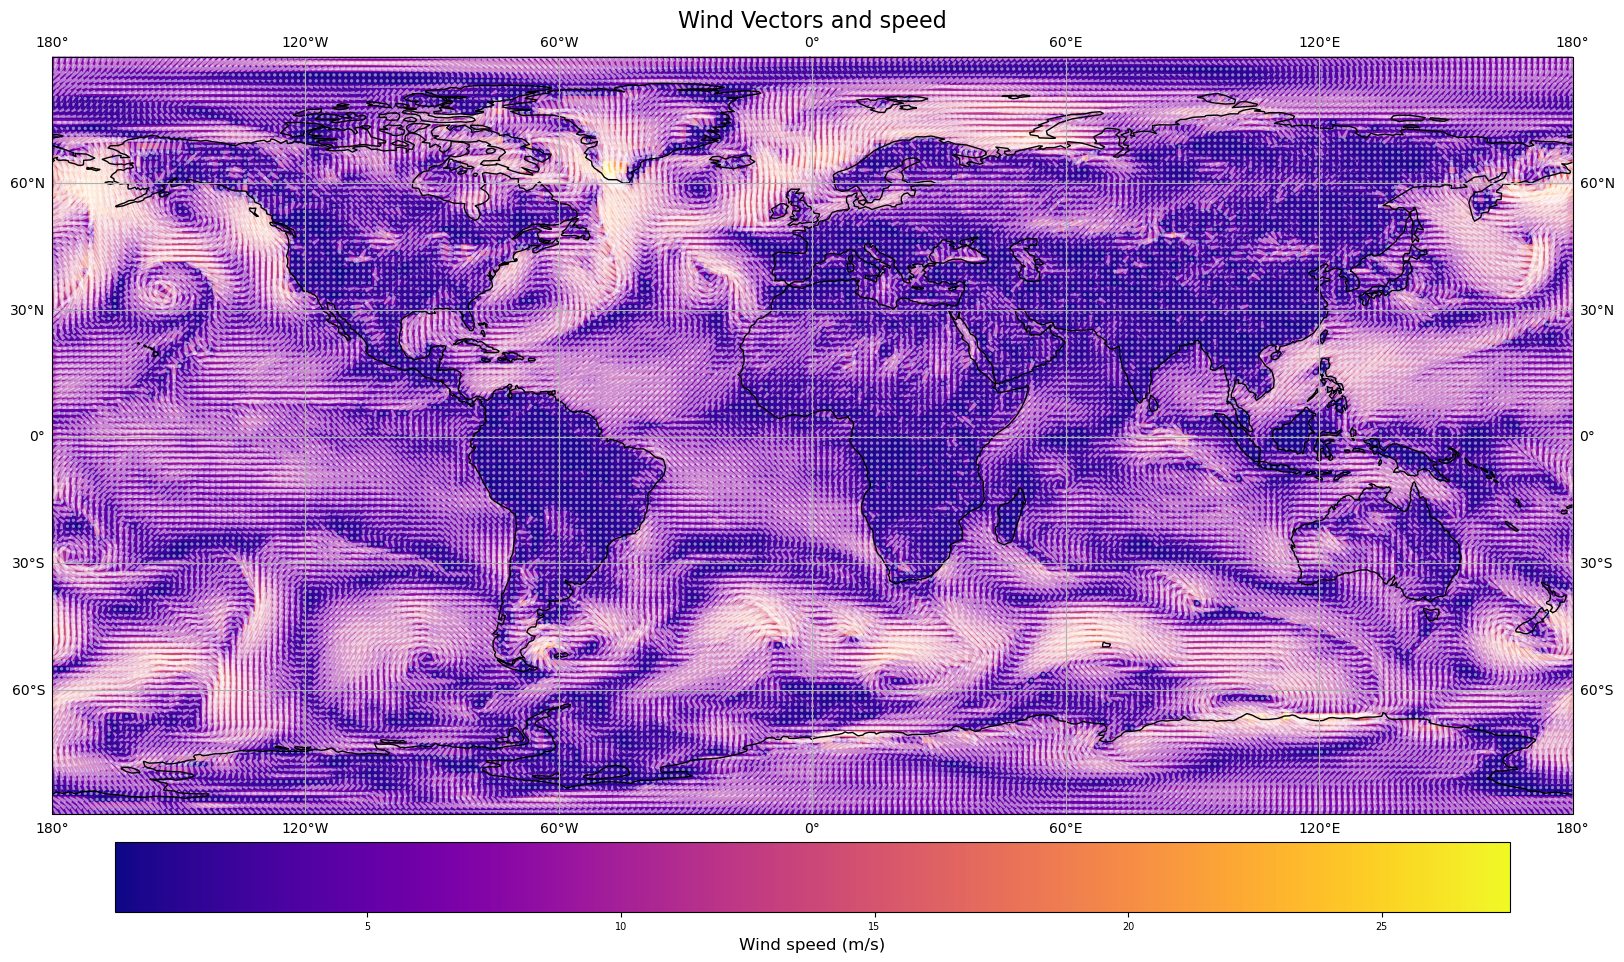

In [16]:
uu = u #.isel(lon=slice(0, -1, 20), lat=slice(1, -1, 20))
vv = v #.isel(lon=slice(0, -1, 20), lat=slice(1, -1, 20))

magnitude = np.sqrt(uu[0]**2 + vv[0]**2)
lns =uu.lon
lts =uu.lat

output_filename = None #'wind_vctrs_overlay.png'
title = 'Wind Vectors and speed'

plot_and_save_wind_ConVec(lns, lts, magnitude, output_filename, title=title, title_size=16,
                               vmin=None, vmax=None, clrmap='plasma', lbl='Wind speed (m/s)', shrnk=.9, lbl_size=12,
                               uwind=uu[0], vwind=vv[0])

***With difference plot***

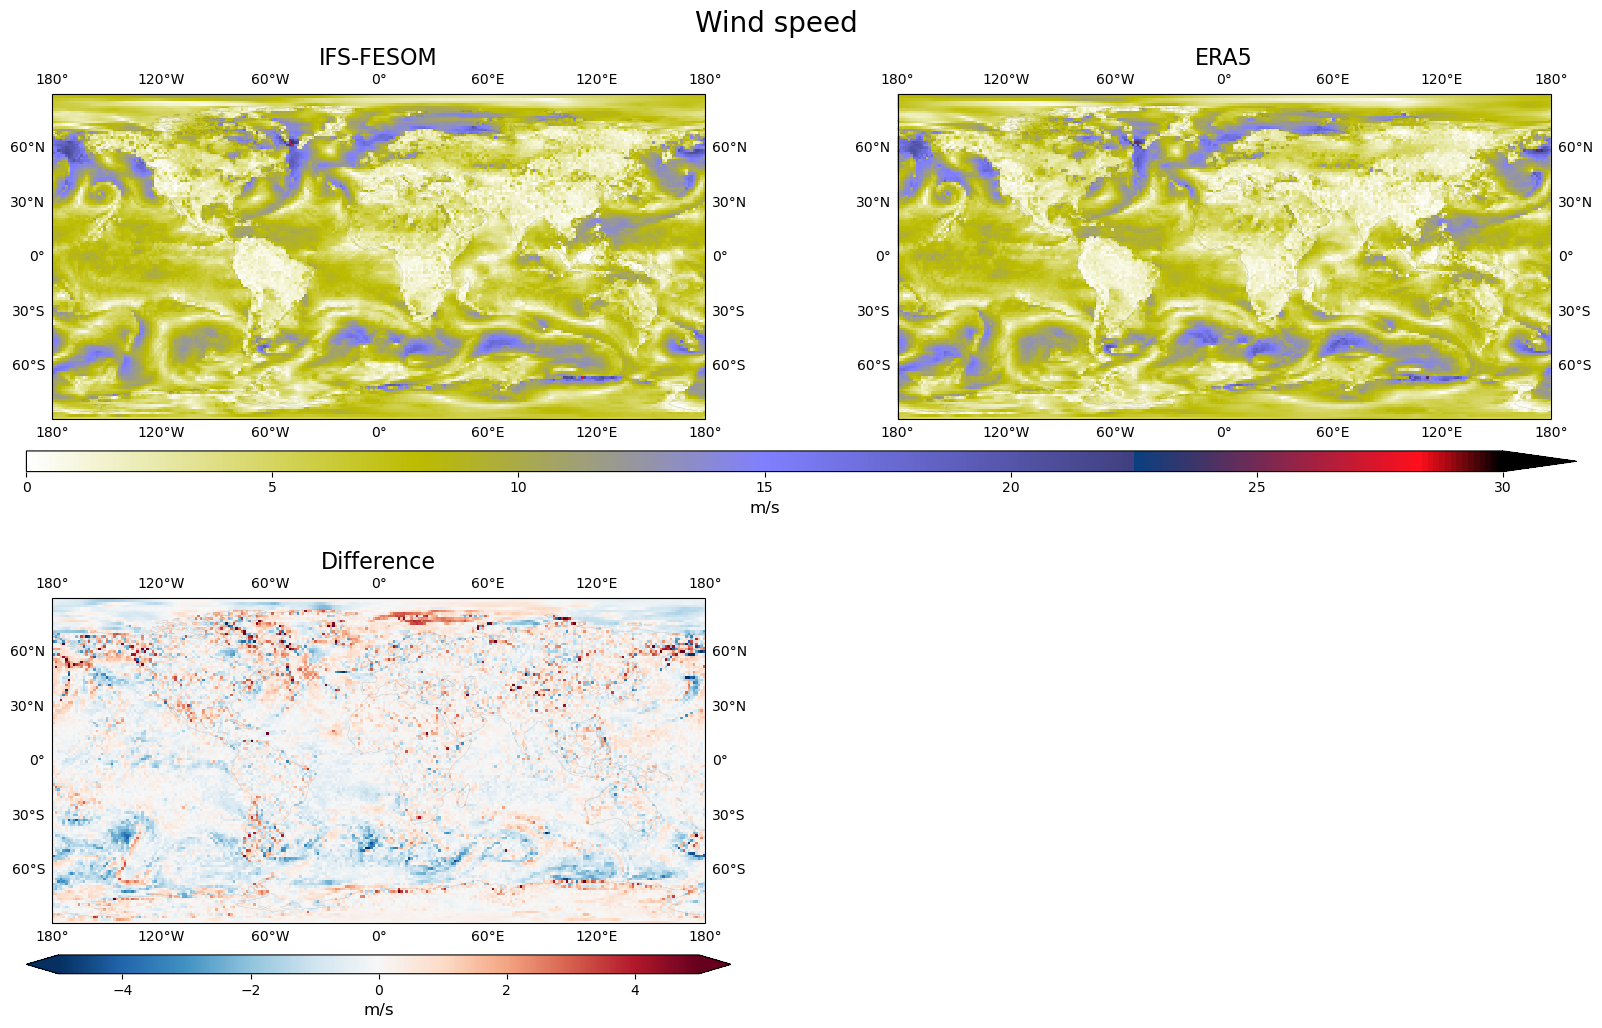

In [17]:
lns =uu.lon
lts =uu.lat
mag1 = np.sqrt(uu[0]**2 + vv[0]**2) 
mag2 = np.sqrt(uu[1]**2 + vv[1]**2)
output_filename = None #'wind_test_diff.png'

plot_and_save_pmesh_diff(lns, lts, mag1, mag2, 
                             output_filename, mntitle='Wind speed', mntpos=0.95,
                             title1='IFS-FESOM', title2='ERA5', title_diff='Difference', 
                             lbl='m/s', lbl_diff='m/s', 
                             lbl_size=12, lbl_size_diff=12, cbht=75, cbht_diff=75/2, 
                             clrmap='gist_stern_r', diff_clrmap='RdBu_r',
                             vmin=0,vmax=30,vmin_diff=-5,vmax_diff=5,
                             triends='max',triends_diff='both',rsltn=300)